%%latex
\tableofcontents

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
import random
import csv
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor 
import matplotlib.cm as cm

# Introduction

The conserved variables are $(D, S_i, \tau)$ and they are related to primitive variables, $w = (\rho, v^i, \epsilon, p)$, defined in the local rest frame of the fluid through (in units of light speed $c = 1$). The P2C is explicitly given:
\begin{equation}
D = \rho W \, , \quad S_i = \rho h W^2 v_i \, , \quad \tau = \rho h W^2 - p - D \, ,
\end{equation}
where we used
\begin{equation}
W = (1 - v^2)^{-1/2} \, , \quad h = 1 + \epsilon + \frac{p}{\rho} \, .
\end{equation}

Our first goal is to reproduce the results from [this paper](https://www.mdpi.com/2073-8994/13/11/2157). A different notebook implemnted the NNEOSB network. Here, we will implement the NNC2P network. We consider an __analytical $\Gamma$-law EOS__ as a benchmark:
\begin{equation}
    p(\rho, \varepsilon) = (\Gamma - 1)\rho\epsilon \, ,
\end{equation}
and we fix $\Gamma = 5/3$ in order to fully mimic the situation of the paper.

# Generating training data

In [2]:
# Define the three functions determining the output
def eos(rho, eps, Gamma = 5/3):
    """Computes the analytical gamma law EOS from rho and epsilon"""
    return (Gamma - 1) * rho * eps

def h(rho, eps, v):
    """Enthalpy"""
    p = eos(rho, eps)
    return 1 + eps + p/rho

def W(rho, eps, v):
    """Lorentz factor. Here, in 1D so v = v_x"""
    return (1-v**2)**(-1/2)

def D(rho, eps, v):
    """See eq 2 paper"""
    return rho*W(rho, eps, v)

def S(rho, eps, v):
    """See eq2 paper. Note: 1D only for now."""
    return rho*h(rho, eps, v)*((W(rho, eps, v))**2)*v

def tau(rho, eps, v):
    """See eq2 paper."""
    return rho*(h(rho, eps, v))*((W(rho, eps, v))**2) - eos(rho, eps) - D(rho, eps, v)

We generate data as follows. We create a training set by randomly sampling as follows:
- $\rho \in (0, 10.1)$,
- $\epsilon \in (0, 2.02)$, 
- $v_x \in (0, 0.721)$.

In [3]:
# Define ranges of parameters to be sampled (see paper Section 2.1)
rho_min = 0
rho_max = 10.1
eps_min = 0
eps_max = 2.02
v_min = 0
v_max = 0.721

Note: the code in comment below was used to generate the data. It has now been saved separately in a folder called "data".

In [4]:
# number_of_datapoints = 10000
# data = []

# for i in range(number_of_datapoints):
#     rho = random.uniform(rho_min, rho_max)
#     eps = random.uniform(eps_min, eps_max)
#     v     = random.uniform(v_min, v_max)
    
#     p               = eos(rho, eps)
#     Dvalue    = D(rho, eps, v)
#     Svalue     = S(rho, eps, v)
#     tauvalue = tau(rho, eps, v)
    
#     new_row = [rho, eps, v, p, Dvalue, Svalue, tauvalue]
    
#     data.append(new_row)

Save the data in a csv file:

In [10]:
# header = ['rho', 'eps', 'v', 'p', 'D', 'S', 'tau']

# with open('data/NNC2P_data_test.csv', 'w', newline = '') as file:
#     writer = csv.writer(file)
#     # write header
#     writer.writerow(header)
#     # write data
#     writer.writerows(data)

In [11]:
# Import data
data_train = pd.read_csv("data/NNC2P_data_train.csv")
data_test = pd.read_csv("data/NNC2P_data_test.csv")
print("The training data has " + str(len(data_train)) + " instances")
print("The test data has " + str(len(data_test)) + " instances")
data_train

The training data has 80000 instances
The test data has 10000 instances


,rho,eps,v,p,D,S,tau
0,0.662984,0.084146,0.218802,0.037192,0.679448,0.173724,0.077335
1,8.565808,0.205945,0.657351,1.176059,11.366755,13.318537,7.718100
2,4.387112,1.598809,0.021593,4.676103,4.388135,0.347321,7.020631
3,5.337054,0.530803,0.351307,1.888615,5.700396,4.031171,3.885760
4,1.133895,0.786717,0.079475,0.594703,1.137493,0.209600,0.905115
...,...,...,...,...,...,...,...
79995,8.101834,0.428605,0.616897,2.314990,10.294002,13.832316,9.813427
79996,7.841014,1.125480,0.209087,5.883268,8.018242,4.930289,9.678536
79997,4.628822,0.194190,0.237759,0.599248,4.765476,1.544018,1.129323
79998,9.913117,1.152242,0.477216,7.614874,11.280468,17.889657,18.592193


# Getting data into PyTorch's DataLoader

Below: `all_data` is of the type $(\rho, \epsilon, v, p, D, S_x, \tau)$ as generated above.

In [12]:
class CustomDataset(Dataset):
    """See PyTorch tutorial: the following three methods HAVE to be implemented"""
    
    def __init__(self, all_data, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        
        # Separate features (rho and eps) from the labels (p, chi, kappa)
        # (see above to get how data is organized)
        features = []
        labels = []
        
        for i in range(len(all_data)):
            # Separate the features
            new_feature = [all_data['D'][i], all_data['S'][i], all_data['tau'][i]]
            features.append(torch.tensor(new_feature, dtype = torch.float32))
            # Separate the labels
            new_label = [all_data['p'][i]]
            labels.append(torch.tensor(new_label, dtype = torch.float32))
            
        # Save as instance variables to the dataloader
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        feature = self.features[idx]
        if self.transform:
            feature = transform(feature)
        label = self.labels[idx]
        if self.target_transform:
            feature = target_transform(label)
            
        return feature, label

Note that the following cell may be confusing. "data_train" refers to the data that was generatd above, see the pandas table. "training_data" is defined similarly as in the PyTorch tutorial, see [this page](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) and this is an instance of the class CustomDataset defined above.

In [13]:
# Make training and test data, as in the tutorial
training_data = CustomDataset(data_train)
test_data = CustomDataset(data_test)

In [14]:
# Check if this is done correctly
print(training_data.features[:3])
print(training_data.labels[:3])

[tensor([0.6794, 0.1737, 0.0773]), tensor([11.3668, 13.3185,  7.7181]), tensor([4.3881, 0.3473, 7.0206])]
[tensor([0.0372]), tensor([1.1761]), tensor([4.6761])]


In [15]:
# Now call DataLoader on the above CustomDataset instances:
train_dataloader = DataLoader(training_data, batch_size=32)
test_dataloader = DataLoader(test_data, batch_size=32)

# Building the neural networks

We will follow [this part of the PyTorch tutorial](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html). For more information, see the [documentation page of torch.nn](https://pytorch.org/docs/stable/nn.html). We take the parameters of NNEOS

In [16]:
# Define hyperparameters of the model here. Will first of all put two hidden layers
# total of 800 neurons for the one in the paper
device = "cpu"
size_HL_1 = 600
size_HL_2 = 200

# Implement neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        #self.flatten = nn.Flatten()
        self.stack = nn.Sequential(
            nn.Linear(3, size_HL_1),
            nn.Sigmoid(),
            nn.Linear(size_HL_1, size_HL_2),
            nn.Sigmoid(),
            nn.Linear(size_HL_2, 1)
        )

    def forward(self, x):
        # No flatten needed, as our input and output are 1D?
        #x = self.flatten(x) 
        logits = self.stack(x)
        return logits

# Training the neural network

We added a regularization term, with a coefficient specified by $\lambda$ ([source](https://androidkt.com/how-to-add-l1-l2-regularization-in-pytorch-loss-function/)).

In [37]:
def compute_loss(pred, y, regularization=False, l1_lambda = 0.001, verbose=False):
    """Adds a regularization term on top of the used loss function.
        Note: Replace abs() with pow(2.0) for L2 regularization"""
    
    # use the specified loss function
    loss = loss_fn(pred, y)
        
    # If we use regularization:
    if regularization:
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss += l1_lambda * l1_norm
            
    return loss

In [38]:
def train_loop(dataloader, model, loss_fn, optimizer, report_progress=False, regularization=False):
    """The training loop of the algorithm"""
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = compute_loss(pred, y,regularization)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # If we want to report progress during training (not recommended - obstructs view)
        if report_progress:
            if batch % 100 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn, regularization=False):
    """The testing loop of the algorithm"""
    num_batches = len(dataloader)
    test_loss = 0

    # Predict and compute losses
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += compute_loss(pred, y, regularization).item()
            
    average_test_loss = test_loss/num_batches
    return average_test_loss

Now we generate an instance of the above neural network in `model` (note: running this cell will create a 'fresh' model!).

Save hyperparameters and loss function - note that we follow the paper. I think that their loss function agrees with [MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss). The paper uses the [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam). More details on optimizers can be found [here](https://pytorch.org/docs/stable/optim.html). Required argument `params` can be filled in by calling `model` which contains the neural network. For simplicity we will train for 10 epochs here.

##### To start a new model:

In [39]:
model = NeuralNetwork().to(device)
print(model)

# Save hyperparameters, loss function and optimizer here (see paper for details)
learning_rate = 6e-4
batch_size = 32
adaptation_threshold = 0.9995
adaptation_multiplier = 0.5

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

NeuralNetwork(
  (stack): Sequential(
    (0): Linear(in_features=3, out_features=600, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=600, out_features=200, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=200, out_features=1, bias=True)
  )
)


##### To go further: 

In [42]:
NNC2P = torch.load('Models/NNC2Pv0.pth')
model = NNC2P

# Save hyperparameters, loss function and optimizer here (see paper for details)
learning_rate = (6e-4)*(0.5**7)
batch_size = 32
adaptation_threshold = 0.9995
adaptation_multiplier = 0.5

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

__Training:__

In [43]:
# Restart training by changing this parameter:
restart = True
abort = False
max_number_epochs = 500

# Initialize lists in case we start a new training loop
if restart:
    confirmation = input("Are you sure you want to restart? Press y >> ")
    if confirmation == "y":
        test_losses = []
        train_losses = []
        train_losses_subset = []
        adaptation_indices = []
        counter = -5 # we skip the very first few iterations before changing learning rate
    else:
        print("Aborting training.")
        abort = True

# Acutal training loop is done:
if abort is False:
    epoch_counter = len(train_losses) + 1

    print("Training the model . . .")
    if restart is False:
        print("(Continued)")
        
    # Training: 
    while epoch_counter < max_number_epochs:
        print(f"\n Epoch {epoch_counter} \n --------------")
        # Train 
        train_loop(train_dataloader, model, loss_fn, optimizer)
        # Test on the training data
        average_train_loss = test_loop(train_dataloader, model, loss_fn)
        train_losses.append(average_train_loss)
        # Test on testing data
        average_test_loss = test_loop(test_dataloader, model, loss_fn)
        test_losses.append(average_test_loss)

        # Update the learning rate - see Appendix B of the paper
        # only check if update needed after 10 new epochs
        if counter >= 10:
            current = np.min(train_losses[-5:])
            previous = np.min(train_losses[-10:-5])

            # If we did not improve the test loss sufficiently, going to adapt LR
            if current/previous >= adaptation_threshold:
                # Reset counter (note: will increment later, so set to -1 st it becomes 0)
                counter = -1
                learning_rate = adaptation_multiplier*learning_rate
                print(f"Adapting learning rate to {learning_rate}")
                # Change optimizer
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
                # Add the epoch time for plotting later on
                adaptation_indices.append(epoch_counter)

        # Report progress:
#         print(f"Average loss of: {average_test_loss} for test data")
        print(f"Average loss of: {average_train_loss} for train data")
        
        # Another epoch passed - increment counter
        counter += 1
        epoch_counter += 1

    print("Done!")

Are you sure you want to restart? Press y >> y
Training the model . . .

 Epoch 1 
 --------------
Average loss of: 3.089510748736757e-07 for train data

 Epoch 2 
 --------------
Average loss of: 3.1202006184400943e-07 for train data

 Epoch 3 
 --------------
Average loss of: 3.124270939736107e-07 for train data

 Epoch 4 
 --------------
Average loss of: 3.1222717097136864e-07 for train data

 Epoch 5 
 --------------
Average loss of: 3.1206473230440677e-07 for train data

 Epoch 6 
 --------------
Average loss of: 3.1187501445799625e-07 for train data

 Epoch 7 
 --------------
Average loss of: 3.116413577288313e-07 for train data

 Epoch 8 
 --------------
Average loss of: 3.1127900743115334e-07 for train data

 Epoch 9 
 --------------
Average loss of: 3.1123996255644214e-07 for train data

 Epoch 10 
 --------------
Average loss of: 3.1089917663109644e-07 for train data

 Epoch 11 
 --------------
Average loss of: 3.106453569586165e-07 for train data

 Epoch 12 
 --------------


Average loss of: 2.943814187830185e-07 for train data

 Epoch 101 
 --------------
Average loss of: 2.9429838032797304e-07 for train data

 Epoch 102 
 --------------
Average loss of: 2.9431710462404224e-07 for train data

 Epoch 103 
 --------------
Average loss of: 2.939490535055711e-07 for train data

 Epoch 104 
 --------------
Average loss of: 2.9390861339209093e-07 for train data

 Epoch 105 
 --------------
Average loss of: 2.9370387892981853e-07 for train data

 Epoch 106 
 --------------
Average loss of: 2.938424497699543e-07 for train data

 Epoch 107 
 --------------
Average loss of: 2.935744289686681e-07 for train data

 Epoch 108 
 --------------
Average loss of: 2.9390165418305967e-07 for train data

 Epoch 109 
 --------------
Average loss of: 2.934056926591211e-07 for train data

 Epoch 110 
 --------------
Average loss of: 2.936016251055662e-07 for train data

 Epoch 111 
 --------------
Average loss of: 2.932211686413666e-07 for train data

 Epoch 112 
 --------------

Average loss of: 2.3221691207027106e-07 for train data

 Epoch 199 
 --------------
Average loss of: 2.3210960129347313e-07 for train data

 Epoch 200 
 --------------
Average loss of: 2.3194871184983868e-07 for train data

 Epoch 201 
 --------------
Average loss of: 2.3191110854696717e-07 for train data

 Epoch 202 
 --------------
Average loss of: 2.3179621514799463e-07 for train data

 Epoch 203 
 --------------
Average loss of: 2.3169611126405698e-07 for train data

 Epoch 204 
 --------------
Average loss of: 2.3155553919735895e-07 for train data

 Epoch 205 
 --------------
Average loss of: 2.3151894441468812e-07 for train data

 Epoch 206 
 --------------
Average loss of: 2.313583858722268e-07 for train data

 Epoch 207 
 --------------
Average loss of: 2.3124507312672905e-07 for train data

 Epoch 208 
 --------------
Average loss of: 2.3115072618651312e-07 for train data

 Epoch 209 
 --------------
Average loss of: 2.3109060112886936e-07 for train data

 Epoch 210 
 --------

Average loss of: 2.2277651131190623e-07 for train data

 Epoch 297 
 --------------
Average loss of: 2.2273698617425452e-07 for train data

 Epoch 298 
 --------------
Average loss of: 2.226414929921816e-07 for train data

 Epoch 299 
 --------------
Average loss of: 2.2249468471500222e-07 for train data

 Epoch 300 
 --------------
Average loss of: 2.2243551401857075e-07 for train data

 Epoch 301 
 --------------
Average loss of: 2.2229588705755531e-07 for train data

 Epoch 302 
 --------------
Average loss of: 2.2225389792112082e-07 for train data

 Epoch 303 
 --------------
Average loss of: 2.2214919874699035e-07 for train data

 Epoch 304 
 --------------
Average loss of: 2.2207352725160945e-07 for train data

 Epoch 305 
 --------------
Average loss of: 2.219762223759858e-07 for train data

 Epoch 306 
 --------------
Average loss of: 2.2190374073574048e-07 for train data

 Epoch 307 
 --------------
Average loss of: 2.2180709780172947e-07 for train data

 Epoch 308 
 ---------

Average loss of: 2.1430189068709638e-07 for train data

 Epoch 395 
 --------------
Average loss of: 2.1424143981292332e-07 for train data

 Epoch 396 
 --------------
Average loss of: 2.1419060314968875e-07 for train data

 Epoch 397 
 --------------
Average loss of: 2.140668665795431e-07 for train data

 Epoch 398 
 --------------
Average loss of: 2.1406529397367534e-07 for train data

 Epoch 399 
 --------------
Average loss of: 2.1389322334144368e-07 for train data

 Epoch 400 
 --------------
Average loss of: 2.1383363194473758e-07 for train data

 Epoch 401 
 --------------
Average loss of: 2.1373576593788358e-07 for train data

 Epoch 402 
 --------------
Average loss of: 2.1365818407517168e-07 for train data

 Epoch 403 
 --------------
Average loss of: 2.1358135660776155e-07 for train data

 Epoch 404 
 --------------
Average loss of: 2.1355117742416497e-07 for train data

 Epoch 405 
 --------------
Average loss of: 2.1343633864745471e-07 for train data

 Epoch 406 
 --------

Average loss of: 2.0698610527603023e-07 for train data

 Epoch 493 
 --------------
Average loss of: 2.0696701947002795e-07 for train data

 Epoch 494 
 --------------
Average loss of: 2.068599752860223e-07 for train data

 Epoch 495 
 --------------
Average loss of: 2.0678265742049006e-07 for train data

 Epoch 496 
 --------------
Average loss of: 2.0666769629400505e-07 for train data

 Epoch 497 
 --------------
Average loss of: 2.0658200339980225e-07 for train data

 Epoch 498 
 --------------
Average loss of: 2.0664350949886056e-07 for train data

 Epoch 499 
 --------------
Average loss of: 2.0649861082375764e-07 for train data
Done!


## Results of training

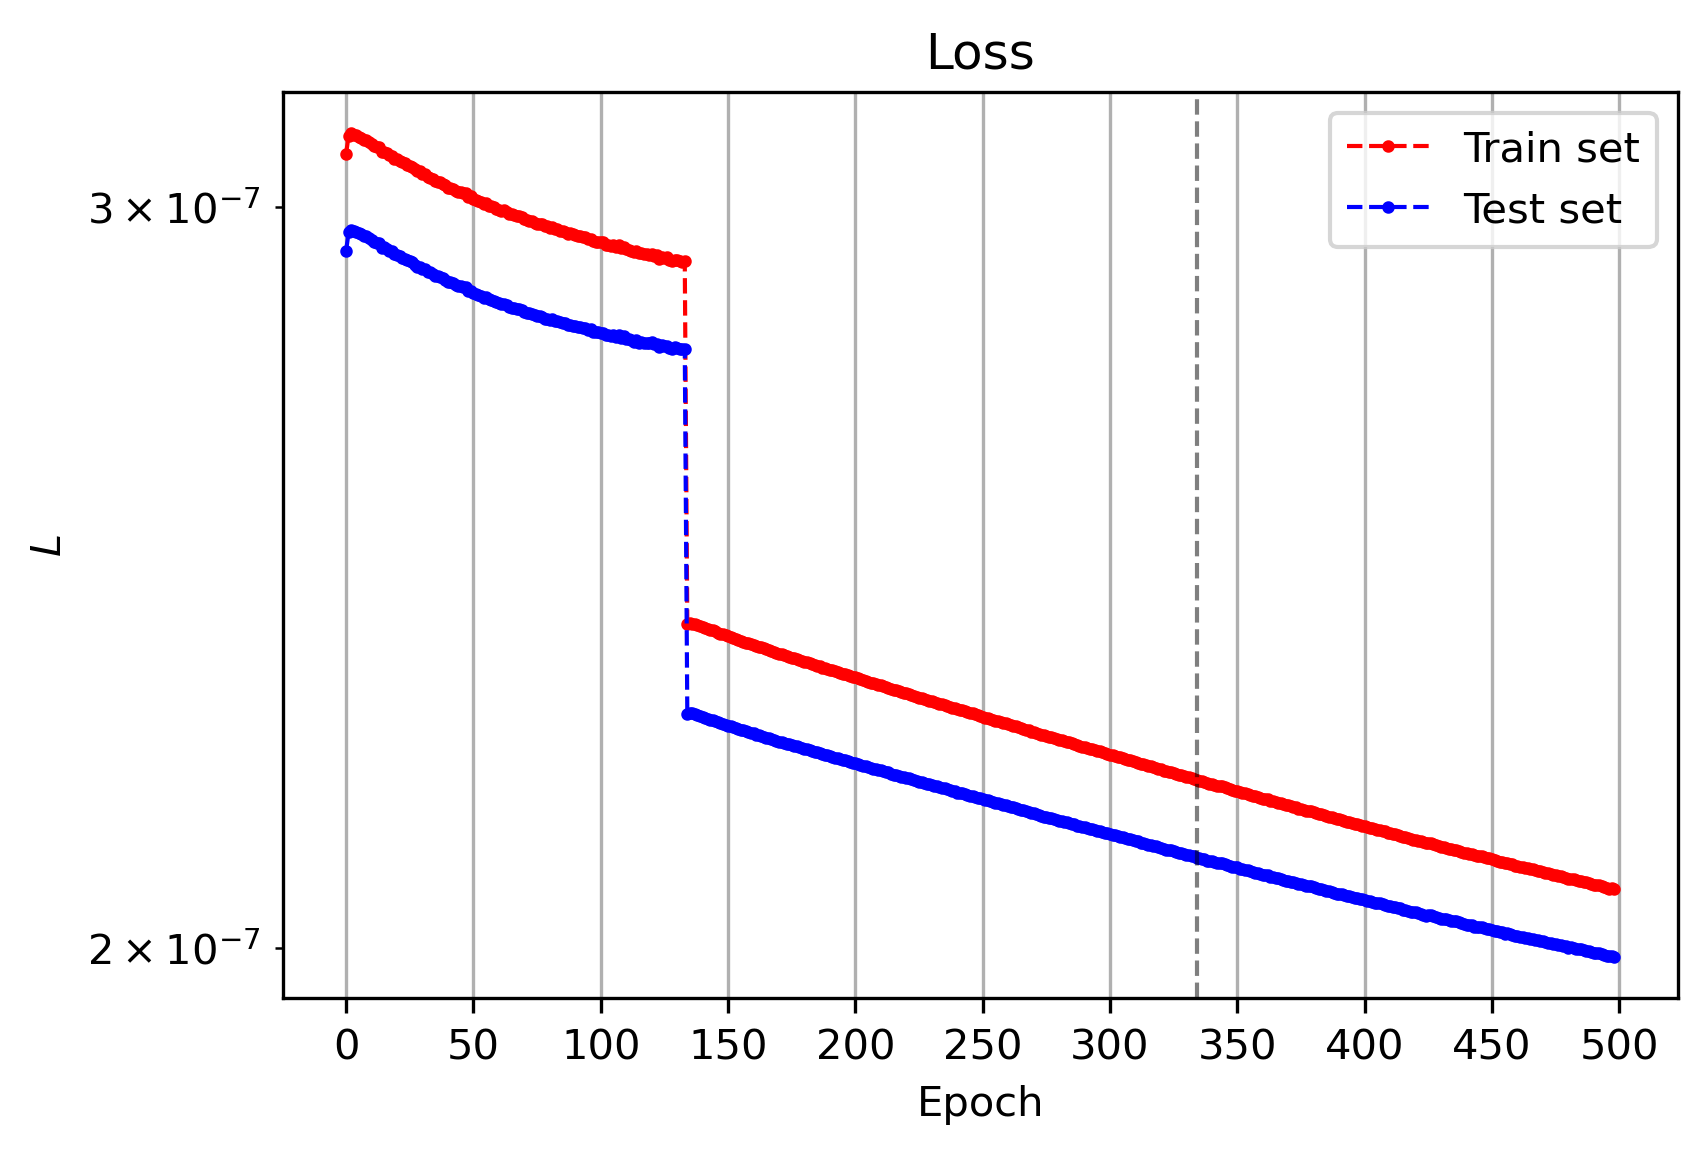

In [44]:
# Plot it
plt.figure()
lw = 1
ms = 2
plt.plot(train_losses, 'o--', color = 'red', label = 'Train set', lw = lw, ms = ms)
plt.plot(test_losses, 'o--', color = 'blue', label = "Test set", lw = lw, ms = ms)
plt.legend()
plt.grid()
plt.xlabel("Epoch")
xt_step = 50
xt = [i*xt_step for i in range(len(train_losses)//xt_step+2)]
plt.xticks(xt)
plt.ylabel(r'$L$')
plt.axhline(0, color = 'black', alpha = 0.7)
plt.title("Loss")
# Plot when we adapted learning rate
for t in adaptation_indices:
    plt.axvline(t+200, linestyle = "--", color = 'black', alpha = 0.5, lw = 1)
plt.yscale('log')
# plt.ylim(10**(-9))
plt.savefig("Plots/NNC2Pv0t2.pdf", bbox_inches = 'tight')
plt.show()

In [87]:
learning_rate

2.34375e-06

In [86]:
# torch.save(new, 'Models/NNC2Pv0t3.pth')

In [80]:
# torch.save(model.state_dict(), 'Models/NNC2Pv0t2_state_dict.pth')

AttributeError: 'collections.OrderedDict' object has no attribute 'state_dict'

# Analyzing neural networks

We import NNC2Pv0, which beats the performance of the models in the paper.

In [88]:
NNC2Pv0t2 = torch.load('Models/NNC2Pv0t2.pth')
model = NNC2Pv0t2

In [89]:
model

NeuralNetwork(
  (stack): Sequential(
    (0): Linear(in_features=3, out_features=600, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=600, out_features=200, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=200, out_features=1, bias=True)
  )
)

## Estimate the performance of the network

In [90]:
def L1_norm(predictions, y):
    """Here, predictions and y are arrays for one specific quantity, eg pressure. See table 1"""
    return sum(abs(predictions - y))/len(predictions)

In [91]:
def Linfty_norm(predictions, y):
    """Here, predictions and y are arrays for one specific quantity, eg pressure. See table 1"""
    return max(abs(predictions - y))

In [92]:
# Get features and labels
test_features = test_data.features
test_labels = test_data.labels
test_features[:4]

[tensor([10.2041, 12.0266, 22.1313]),
 tensor([ 7.0046, 22.3374, 21.0772]),
 tensor([ 9.5747, 10.5188, 10.0152]),
 tensor([0.7725, 1.8519, 1.8100])]

In [93]:
test_features[0]

tensor([10.2041, 12.0266, 22.1313])

In [95]:
# Get predictions
with torch.no_grad():
    p_hat= np.array([])
    for input_values in test_features:
        prediction = model(input_values)
        p_hat = np.append(p_hat, prediction[0].item())

In [96]:
# Get labels as np arrays
p = np.array([])
for value in test_labels:
    p = np.append(p, value[0].item())

In [97]:
# Get the errors:
delta_p_L1 = L1_norm(p_hat, p)
delta_p_Linfty = Linfty_norm(p_hat, p)

In [98]:
print("Errors for p: %e  with L1 and %e with Linfty" % (delta_p_L1, delta_p_Linfty) )

Errors for p: 2.623259e-04  with L1 and 8.344986e-03 with Linfty


In [67]:
# torch.save(model, 'Models/NNC2Pv0.pth')

## Estimate the performance on unseen/untrained cases:

Here, we check the performance whenever we use the model on values on which it wasn't trained. Is there a large error compared to the case of seen data?

### When only one parameter gets outside of its range

In [104]:
# We are going to save the performance according to the ranges specified:
# this dict is filled with the errors we found above
errors_dict = {
    "rho max": [rho_max],
    "eps max":[eps_max],
    "v max":[v_max],
    "L1":[delta_p_L1],
    "Linfty":[delta_p_Linfty]}

# Get the parameters we are going to test

# This is how we are going to increment the upper bound each run
delta_rho = 0.01
delta_eps = 0.01
delta_v     = 0.001

number_of_runs = 100

# Construct the parameters
rho_list = [[rho_max + i*delta_rho, eps_max, v_max] for i in range(1, number_of_runs)]
eps_list = [[rho_max, eps_max + i*delta_eps, v_max] for i in range(1, number_of_runs)]
v_list = [[rho_max, eps_max, v_max + i*delta_v] for i in range(1, number_of_runs)]

parameters_list = rho_list + eps_list + v_list 

In [105]:
number_of_datapoints = 10000

p = []
phat = []

with torch.no_grad():
    # Iterate over all parameter bounds
    for [rho_bound, eps_bound, v_bound] in parameters_list:
        # Save current value:
        errors_dict["rho max"].append(rho_bound)
        errors_dict["eps max"].append(eps_bound)
        errors_dict["v max"].append(v_bound)
        
        # Now get 10 000 new cases and predictions
        for i in range(number_of_datapoints):
            
            # Sample randomly from the new range
            rho = random.uniform(rho_min, rho_bound)
            eps = random.uniform(eps_min, eps_bound)
            v     = random.uniform(v_min,           v_bound)
            
            # Get true value
            p.append(eos(rho, eps))

            # Get the prediction
            
            # Compute features (D, S, tau)
            Dvalue    = D(rho, eps, v)
            Svalue     = S(rho, eps, v)
            tauvalue = tau(rho, eps, v)
            
            # Get prediction
            prediction = model(torch.tensor([Dvalue, Svalue, tauvalue]))
            phat.append(prediction[0].item())
            
        # All values computed, store the errors we found
        L1 = L1_norm(np.array(p), np.array(phat))
        errors_dict["L1"].append(L1)
        Linfty= Linfty_norm(np.array(p), np.array(phat))
        errors_dict["Linfty"].append(Linfty)

In [110]:
df = pd.DataFrame(errors_dict)
df

,rho max,eps max,v max,L1,Linfty
0,10.10,2.02,0.721,0.000361,0.008647
1,10.11,2.02,0.721,0.000368,0.008856
2,10.12,2.02,0.721,0.000367,0.010107
3,10.13,2.02,0.721,0.000370,0.010107
4,10.14,2.02,0.721,0.000367,0.010107
...,...,...,...,...,...
293,10.10,2.02,0.816,0.004811,3.184771
294,10.10,2.02,0.817,0.004801,3.184771
295,10.10,2.02,0.818,0.004790,3.184771
296,10.10,2.02,0.819,0.004780,3.184771


In [114]:
sub_df_rho = df.loc[(df["eps max"] == eps_max) & (df["v max"] == v_max)]
sub_df_eps = df.loc[(df["rho max"] == rho_max) & (df["v max"] == v_max)]
sub_df_v = df.loc[(df["rho max"] == rho_max) & (df["eps max"] == eps_max)]

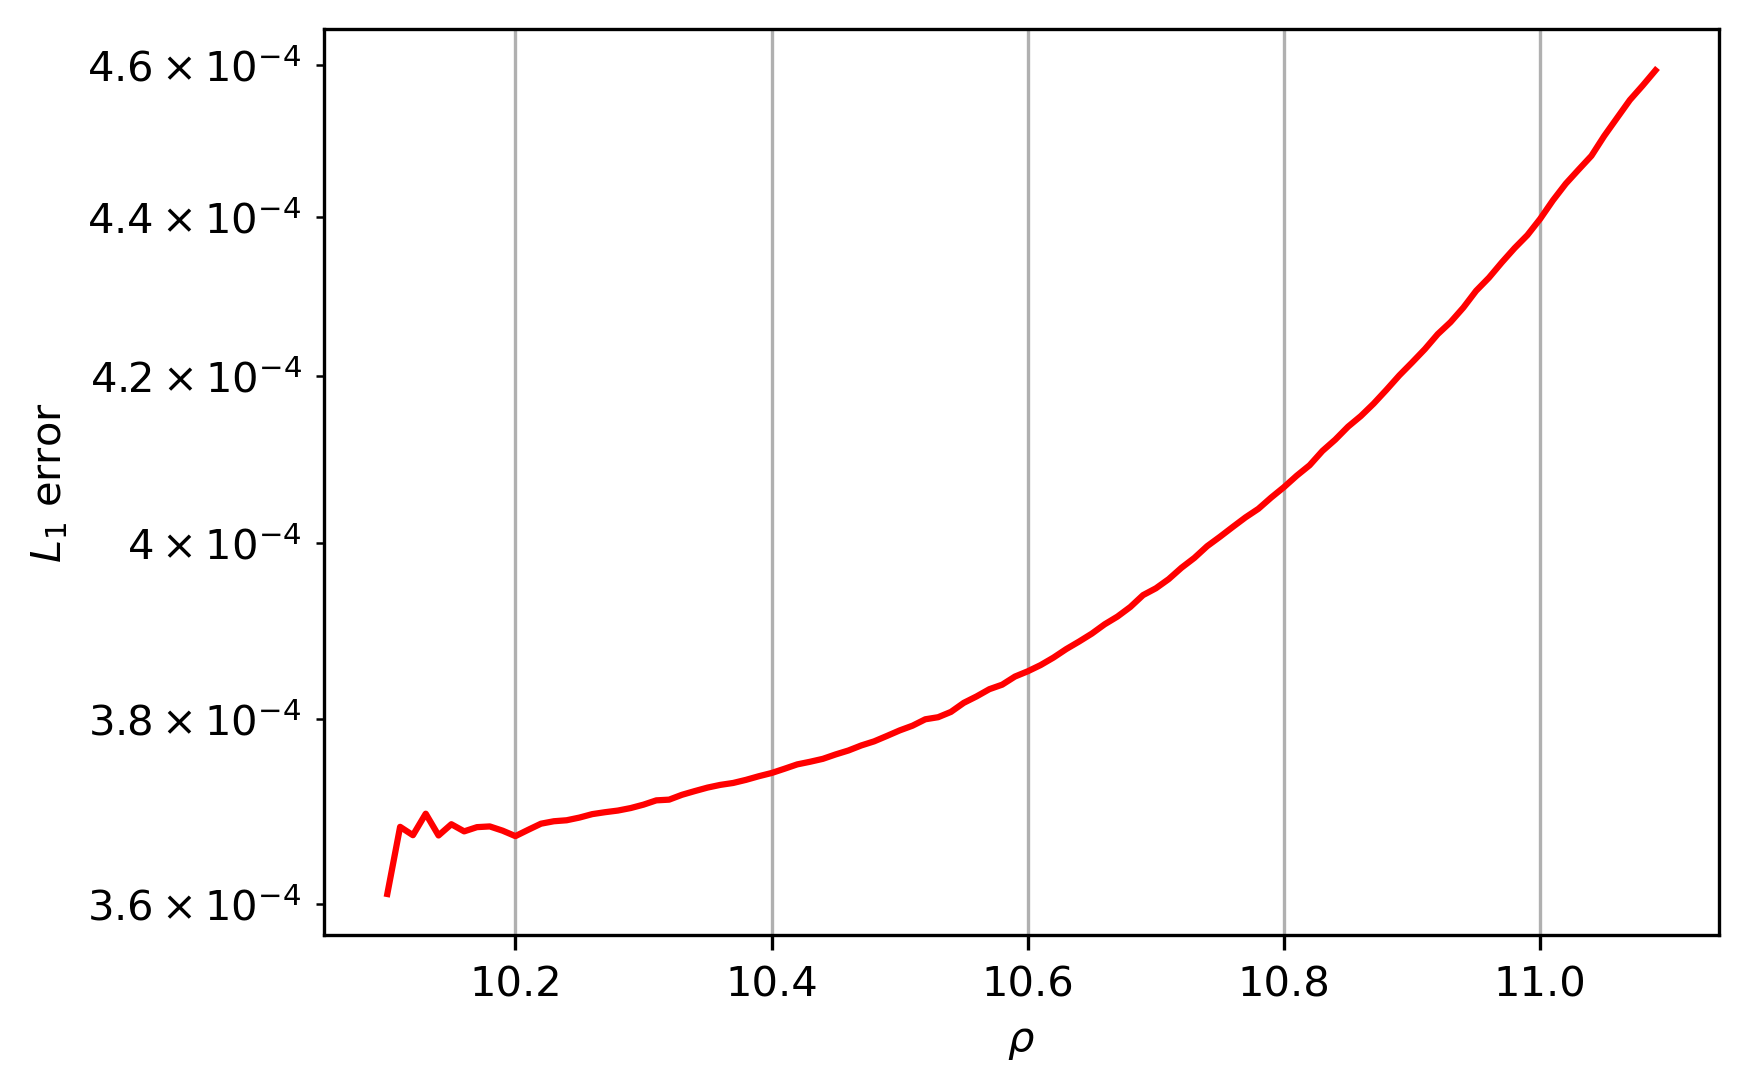

In [119]:
plt.plot(sub_df_rho["rho max"], sub_df_rho["L1"], color='red', label='rho')
# plt.legend()
plt.xlabel(r"$\rho$")
plt.ylabel(r"$L_1$ error")
plt.yscale('log')
plt.grid()
plt.savefig("error_analysis_v1_rho.pdf", bbox_inches='tight')
plt.show()

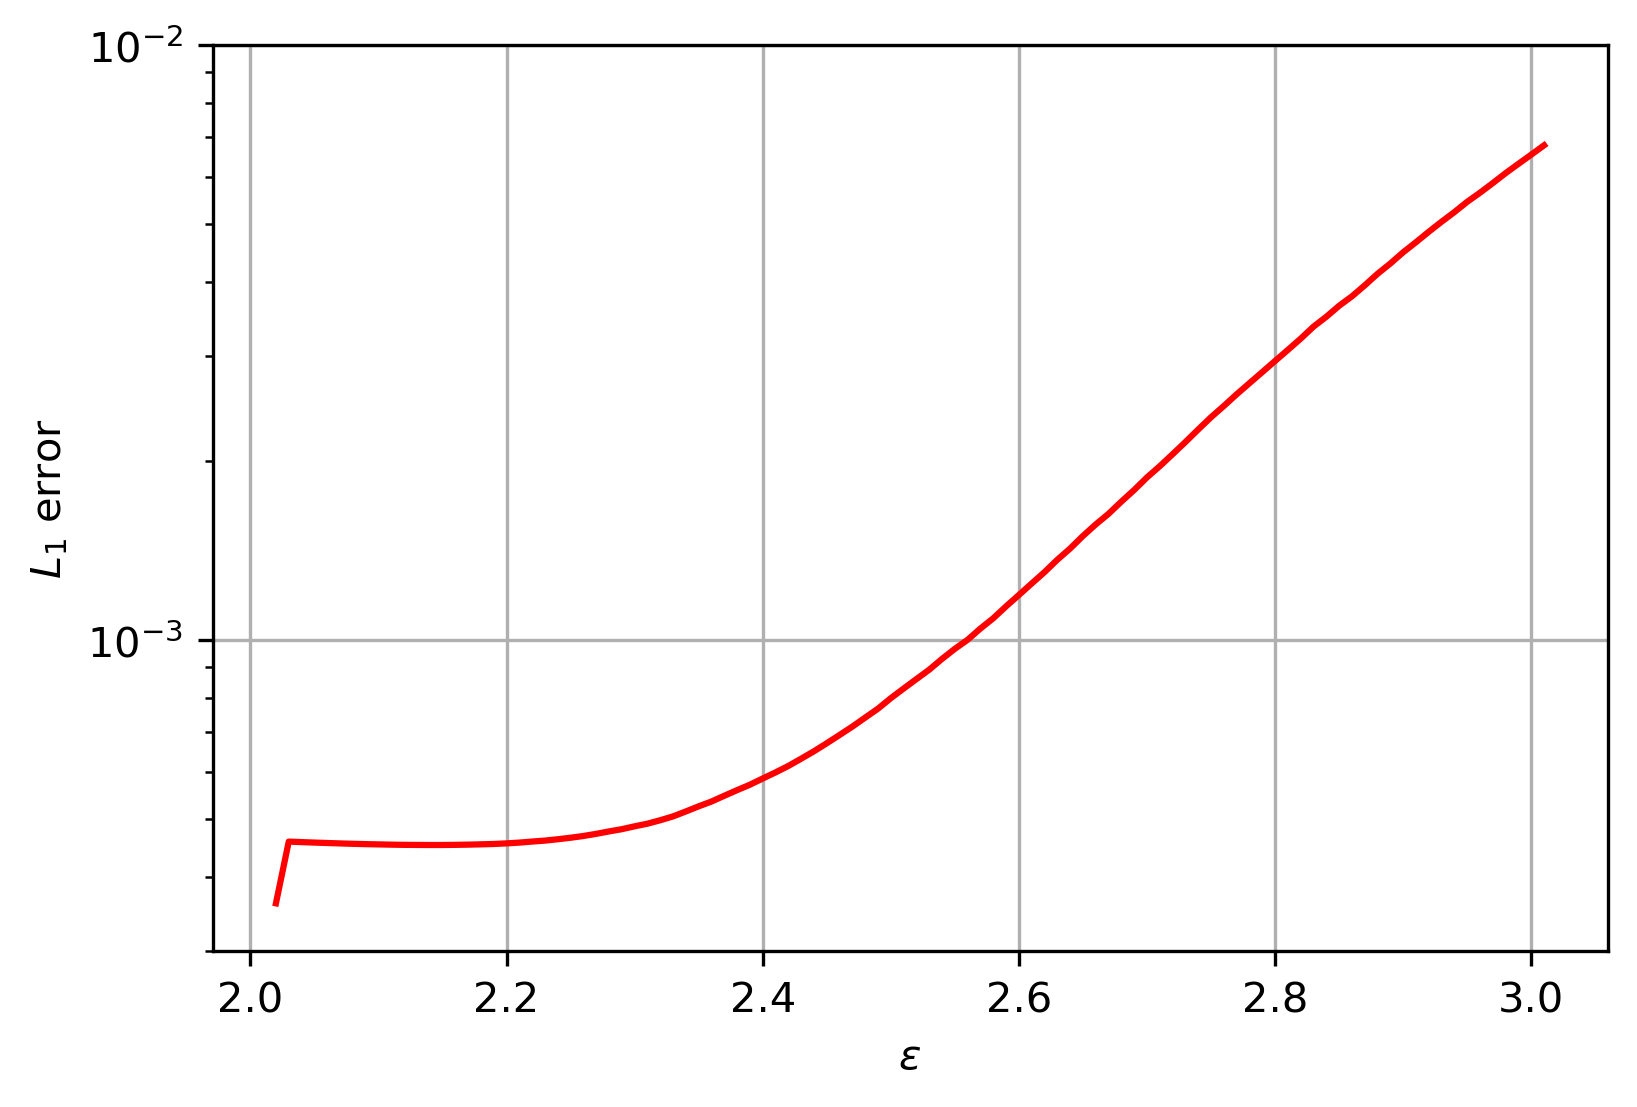

In [130]:
plt.plot(sub_df_eps["eps max"], sub_df_eps["L1"], color='red', label='rho')
# plt.legend()
plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$L_1$ error")
plt.yscale('log')
plt.ylim(3*10**(-4), 10**(-2))
plt.grid()
plt.savefig("error_analysis_v1_eps.pdf", bbox_inches='tight')
plt.show()

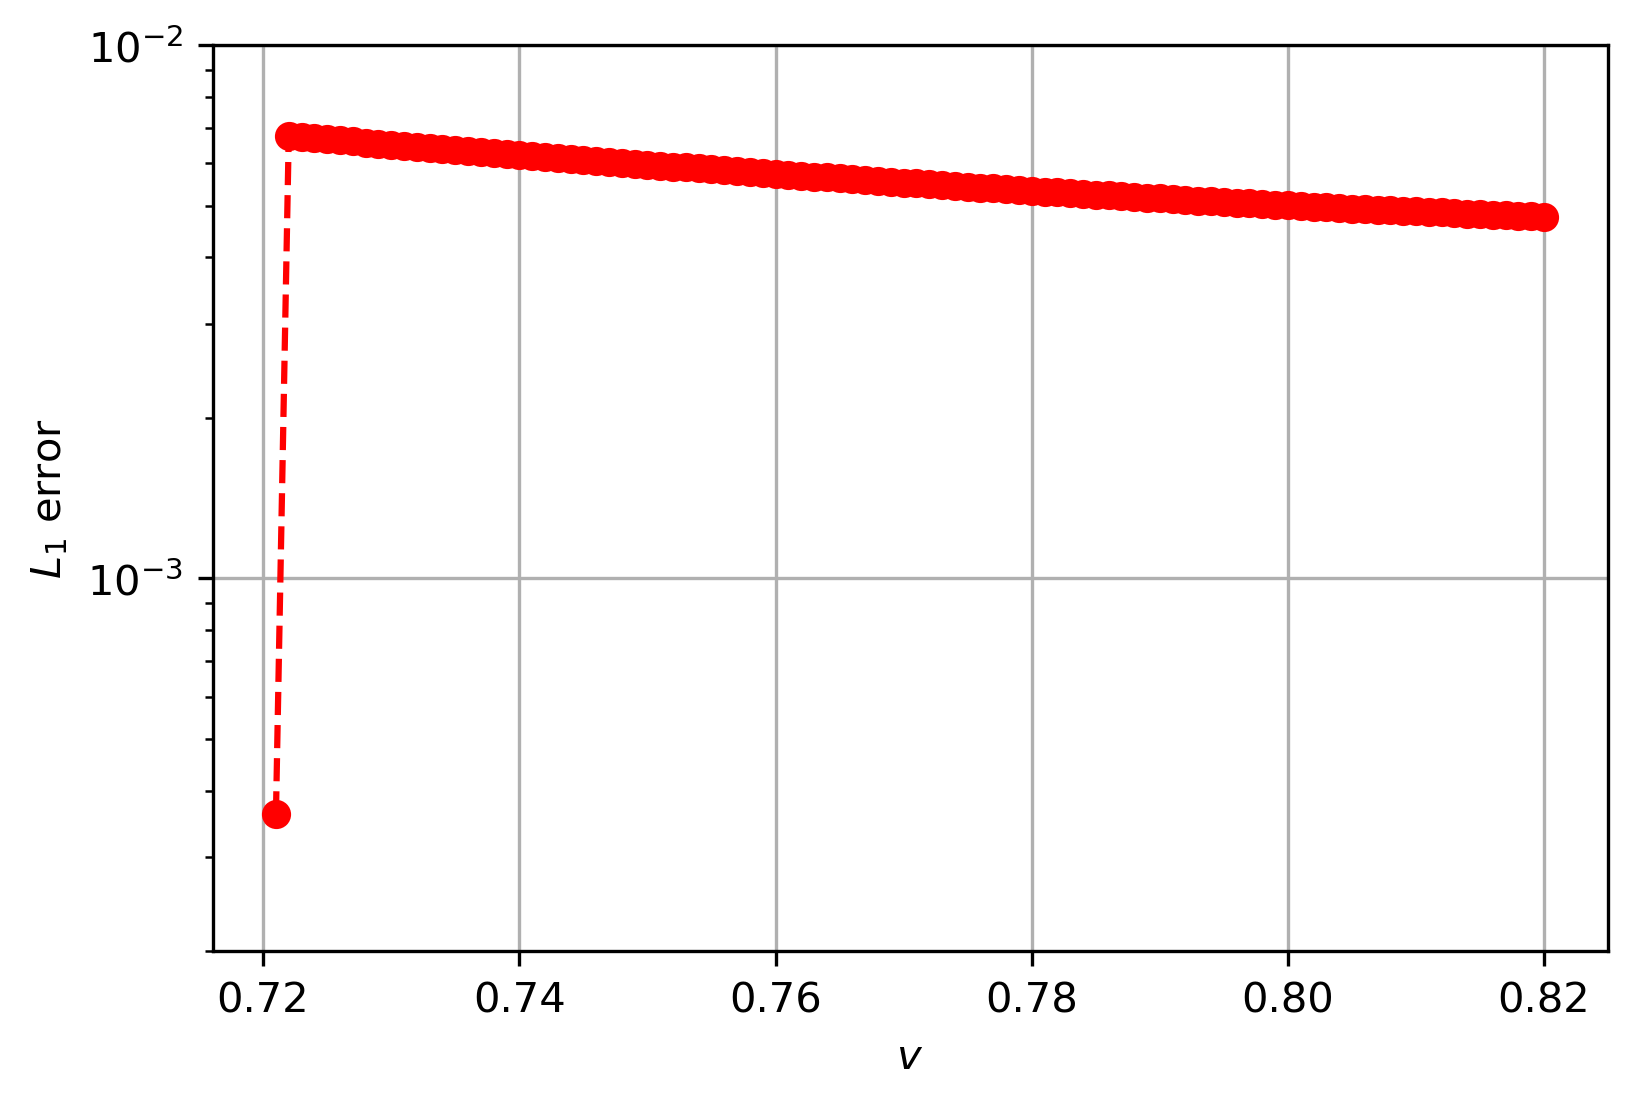

In [129]:
plt.plot(sub_df_v["v max"], sub_df_v["L1"], '--o', color='red', label='rho')
# plt.legend()
plt.xlabel(r"$v$")
plt.ylabel(r"$L_1$ error")
plt.yscale('log')
plt.ylim(2*10**(-4), 10**(-2))
plt.grid()
plt.savefig("error_analysis_v1_v.pdf", bbox_inches='tight')
plt.show()

Save this data to process later on:

In [107]:
# df.to_csv("Data/errors_analysis_v2.csv")

### When all parameters can go outside of their ranges

In [136]:
# We are going to save the performance according to the ranges specified:
# this dict is filled with the errors we found above
errors_dict = {
    "rho max": [rho_max],
    "eps max":[eps_max],
    "v max":[v_max],
    "L1":[delta_p_L1],
    "Linfty":[delta_p_Linfty]}

# Get the parameters we are going to test

# This is how we are going to increment the upper bound each run
delta_rho = 0.02
delta_eps = 0.02
delta_v     = 0.002

number_of_runs = 10

# Construct the parameters
rho_list = [rho_max + i*delta_rho for i in range(1, number_of_runs)]
eps_list = [eps_max + i*delta_eps for i in range(1, number_of_runs)]
v_list      = [v_max     + i*delta_v for i in range(1, number_of_runs)]

In [138]:
number_of_datapoints = 10000

p = []
phat = []

with torch.no_grad():
    # Iterate over all parameter bounds
    for rho_bound in rho_list:
        for eps_bound in eps_list:
            for v_bound in v_list:
                    # Save current values:
                    errors_dict["rho max"].append(rho_bound)
                    errors_dict["eps max"].append(eps_bound)
                    errors_dict["v max"].append(v_bound)

                    # Now get 10 000 new cases and predictions
                    for i in range(number_of_datapoints):

                        # Sample randomly from the new range
                        rho = random.uniform(rho_min, rho_bound)
                        eps = random.uniform(eps_min, eps_bound)
                        v     = random.uniform(v_min,           v_bound)

                        # Get true value
                        p.append(eos(rho, eps))

                        # Get the prediction

                        # Compute features (D, S, tau)
                        Dvalue    = D(rho, eps, v)
                        Svalue     = S(rho, eps, v)
                        tauvalue = tau(rho, eps, v)

                        # Get prediction
                        prediction = model(torch.tensor([Dvalue, Svalue, tauvalue]))
                        phat.append(prediction[0].item())

                    # All values computed, store the errors we found
                    L1 = L1_norm(np.array(p), np.array(phat))
                    errors_dict["L1"].append(L1)
                    Linfty= Linfty_norm(np.array(p), np.array(phat))
                    errors_dict["Linfty"].append(Linfty)

In [139]:
df = pd.DataFrame(errors_dict)
df

,rho max,eps max,v max,L1,Linfty
0,10.10,2.02,0.721,0.000361,0.008647
1,10.12,2.04,0.723,0.000368,0.009280
2,10.12,2.04,0.725,0.000369,0.009725
3,10.12,2.04,0.727,0.000371,0.009725
4,10.12,2.04,0.729,0.000373,0.009725
...,...,...,...,...,...
725,10.28,2.20,0.731,0.000463,0.135447
726,10.28,2.20,0.733,0.000463,0.135447
727,10.28,2.20,0.735,0.000463,0.135447
728,10.28,2.20,0.737,0.000464,0.135447


In [150]:
sub_df_rho_eps = df.loc[(df["v max"] == v_max) |( df["v max"] == v_max+delta_v)]
sub_df_rho_v = df.loc[(df["eps max"] == eps_max) |( df["eps max"] == eps_max+delta_eps)]
sub_df_eps_v = df.loc[(df["rho max"] == rho_max) |( df["rho max"] == rho_max+delta_rho)]

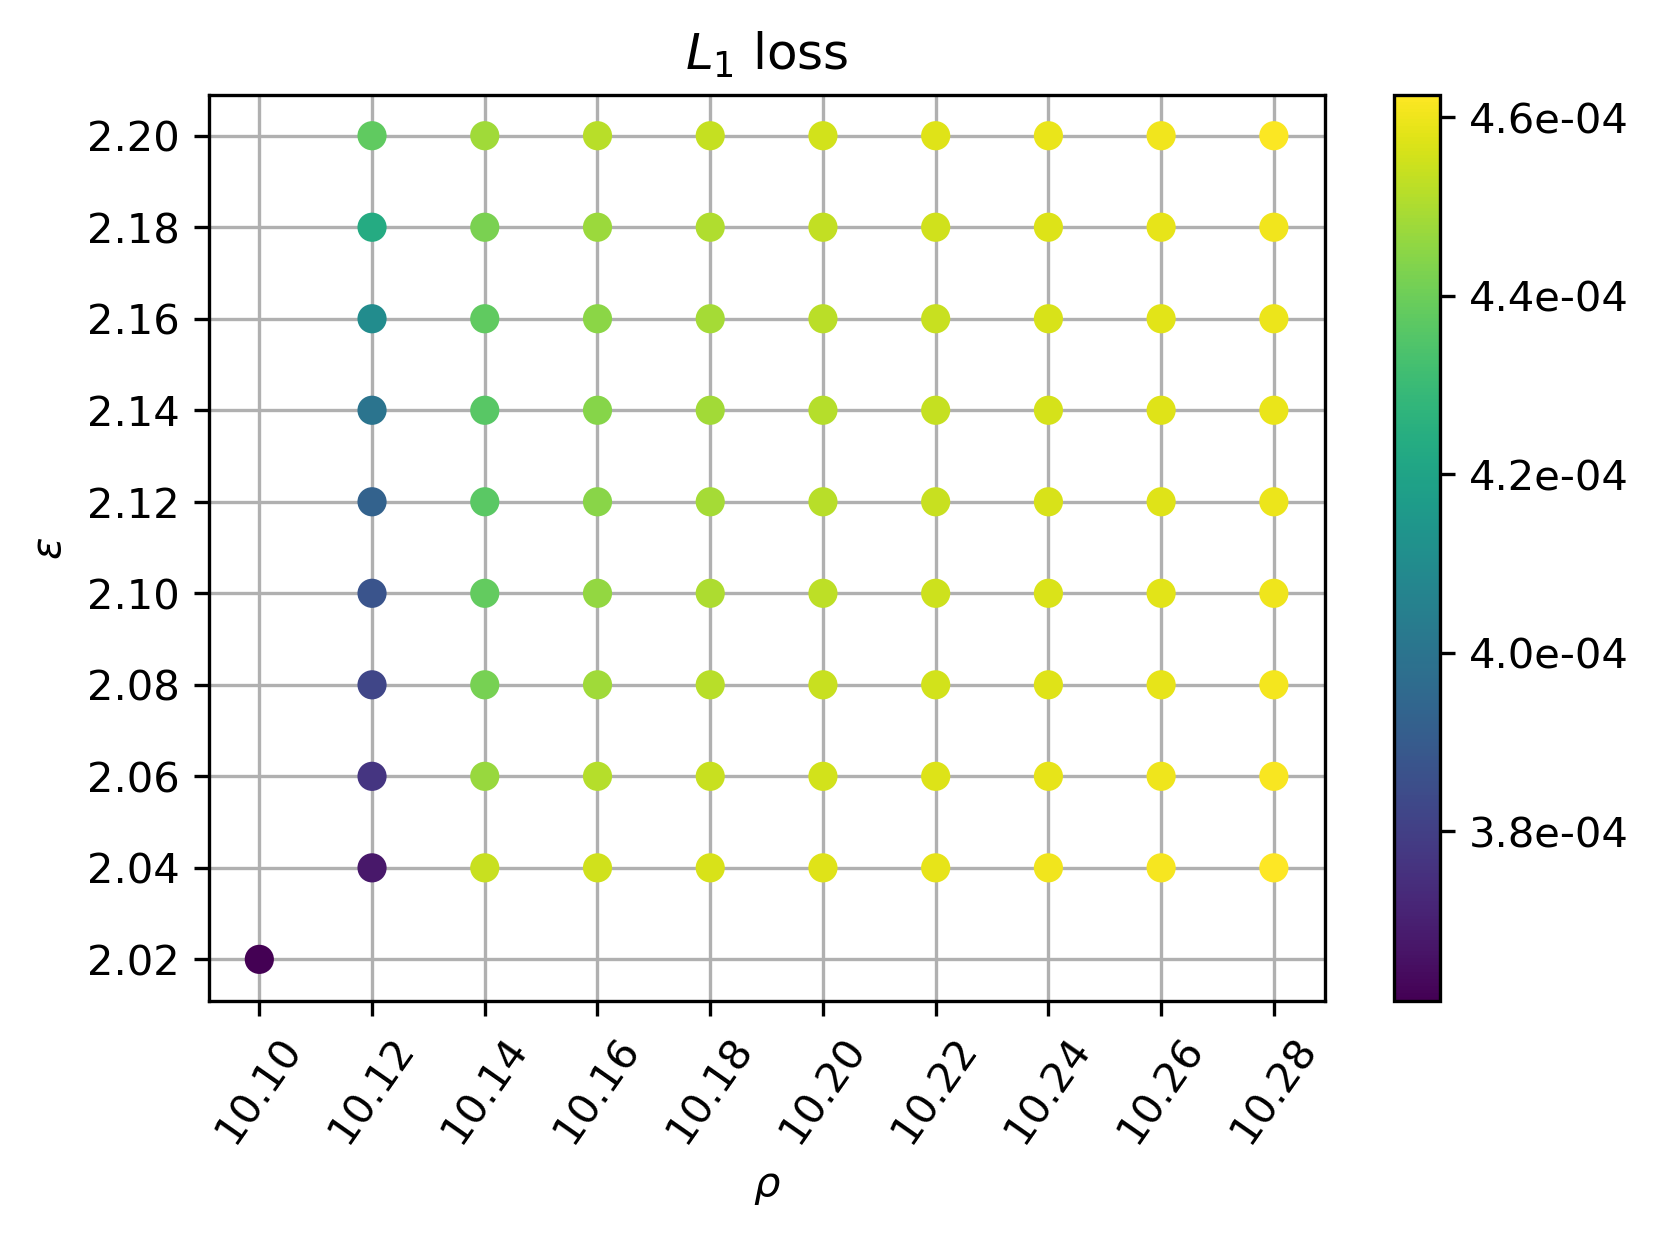

In [178]:
plt.scatter(sub_df_rho_eps["rho max"], sub_df_rho_eps["eps max"], c=sub_df_rho_eps["L1"], zorder=5)
plt.colorbar(format='%0.1e')
plt.xlabel(r"$\rho$")
plt.ylabel(r"$\varepsilon$")
plt.xticks(list(set(sub_df_rho_eps["rho max"])), rotation=55)
plt.yticks(list(set(sub_df_rho_eps["eps max"])))
plt.grid()
plt.title(r"$L_1$ loss")
plt.savefig("error_analysis_rho_eps.pdf", bbox_inches='tight')
plt.show()

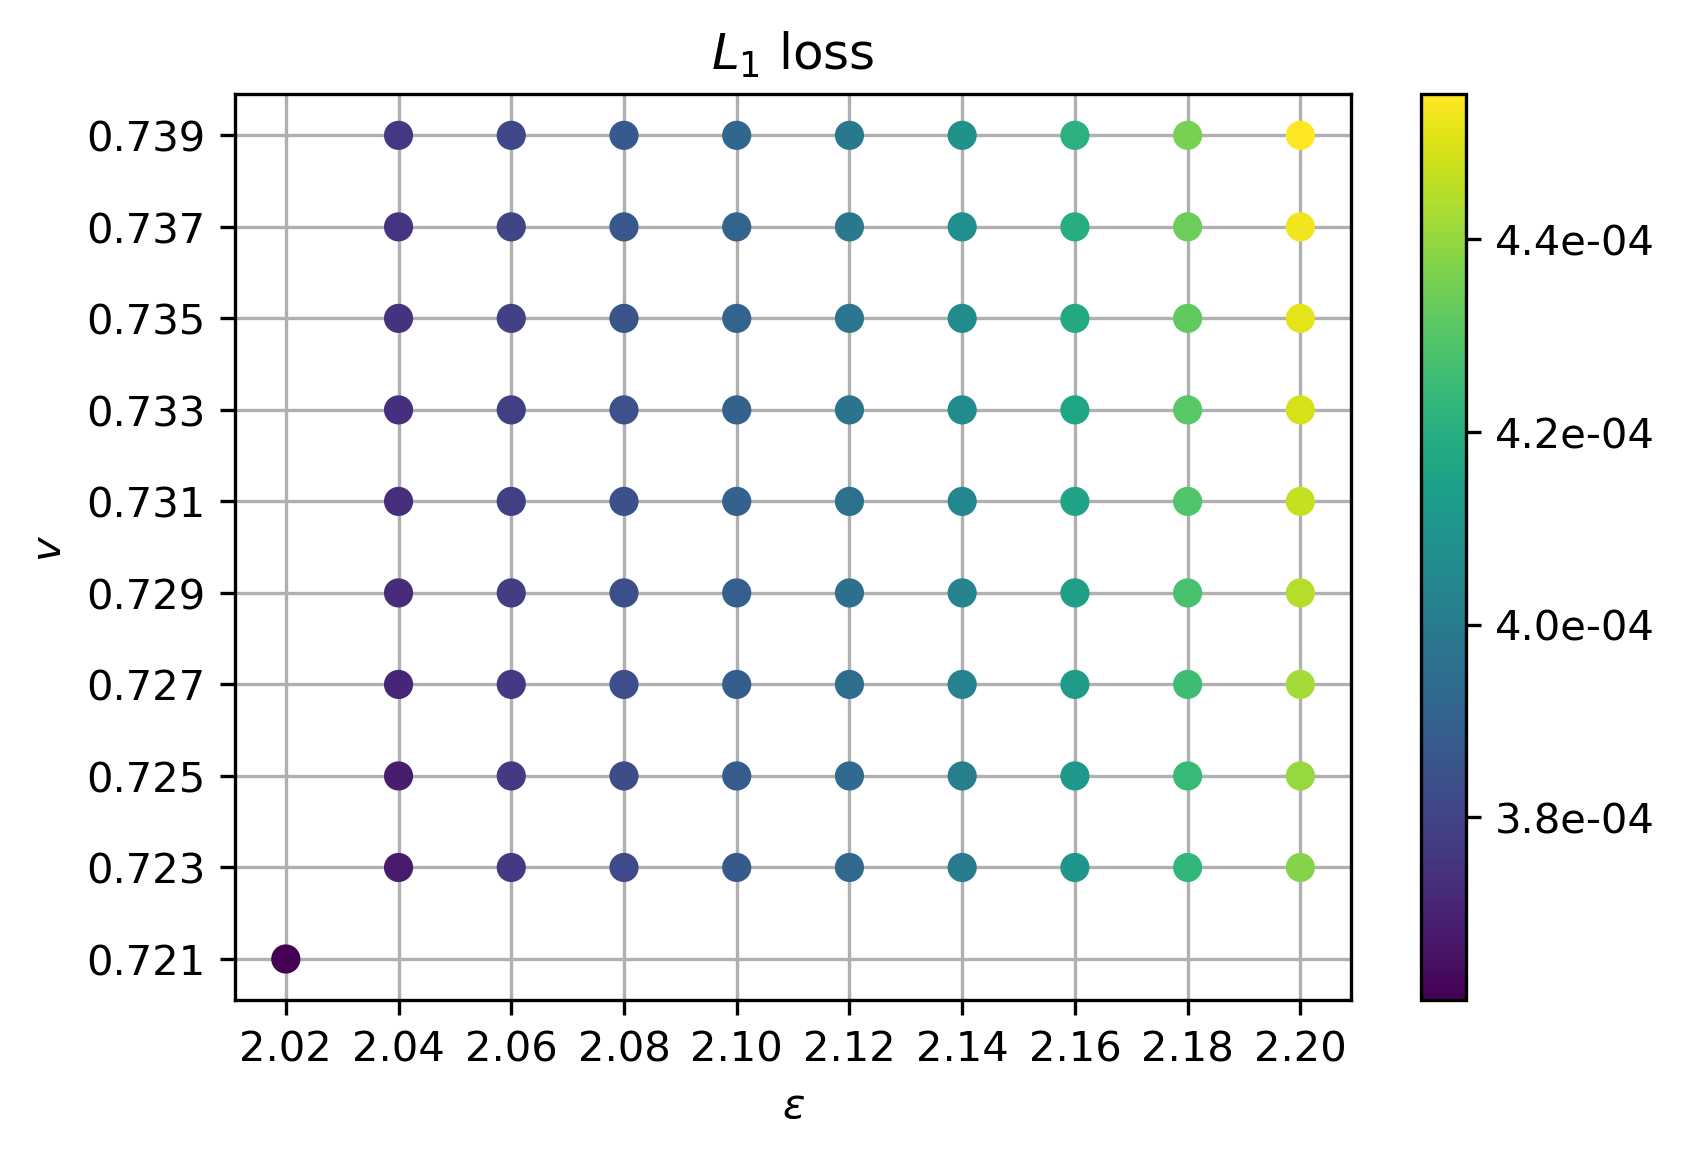

In [180]:
plt.scatter(sub_df_eps_v["eps max"], sub_df_eps_v["v max"], c=sub_df_eps_v["L1"], zorder=5)
plt.colorbar(format='%0.1e')
plt.xticks(list(set(sub_df_eps_v["eps max"])))
plt.yticks(list(set(sub_df_eps_v["v max"])))
plt.grid()
plt.xlabel(r"$\varepsilon$")
plt.ylabel(r"$v$")
plt.title(r"$L_1$ loss")
plt.savefig("error_analysis_eps_v.pdf", bbox_inches='tight')
plt.show()

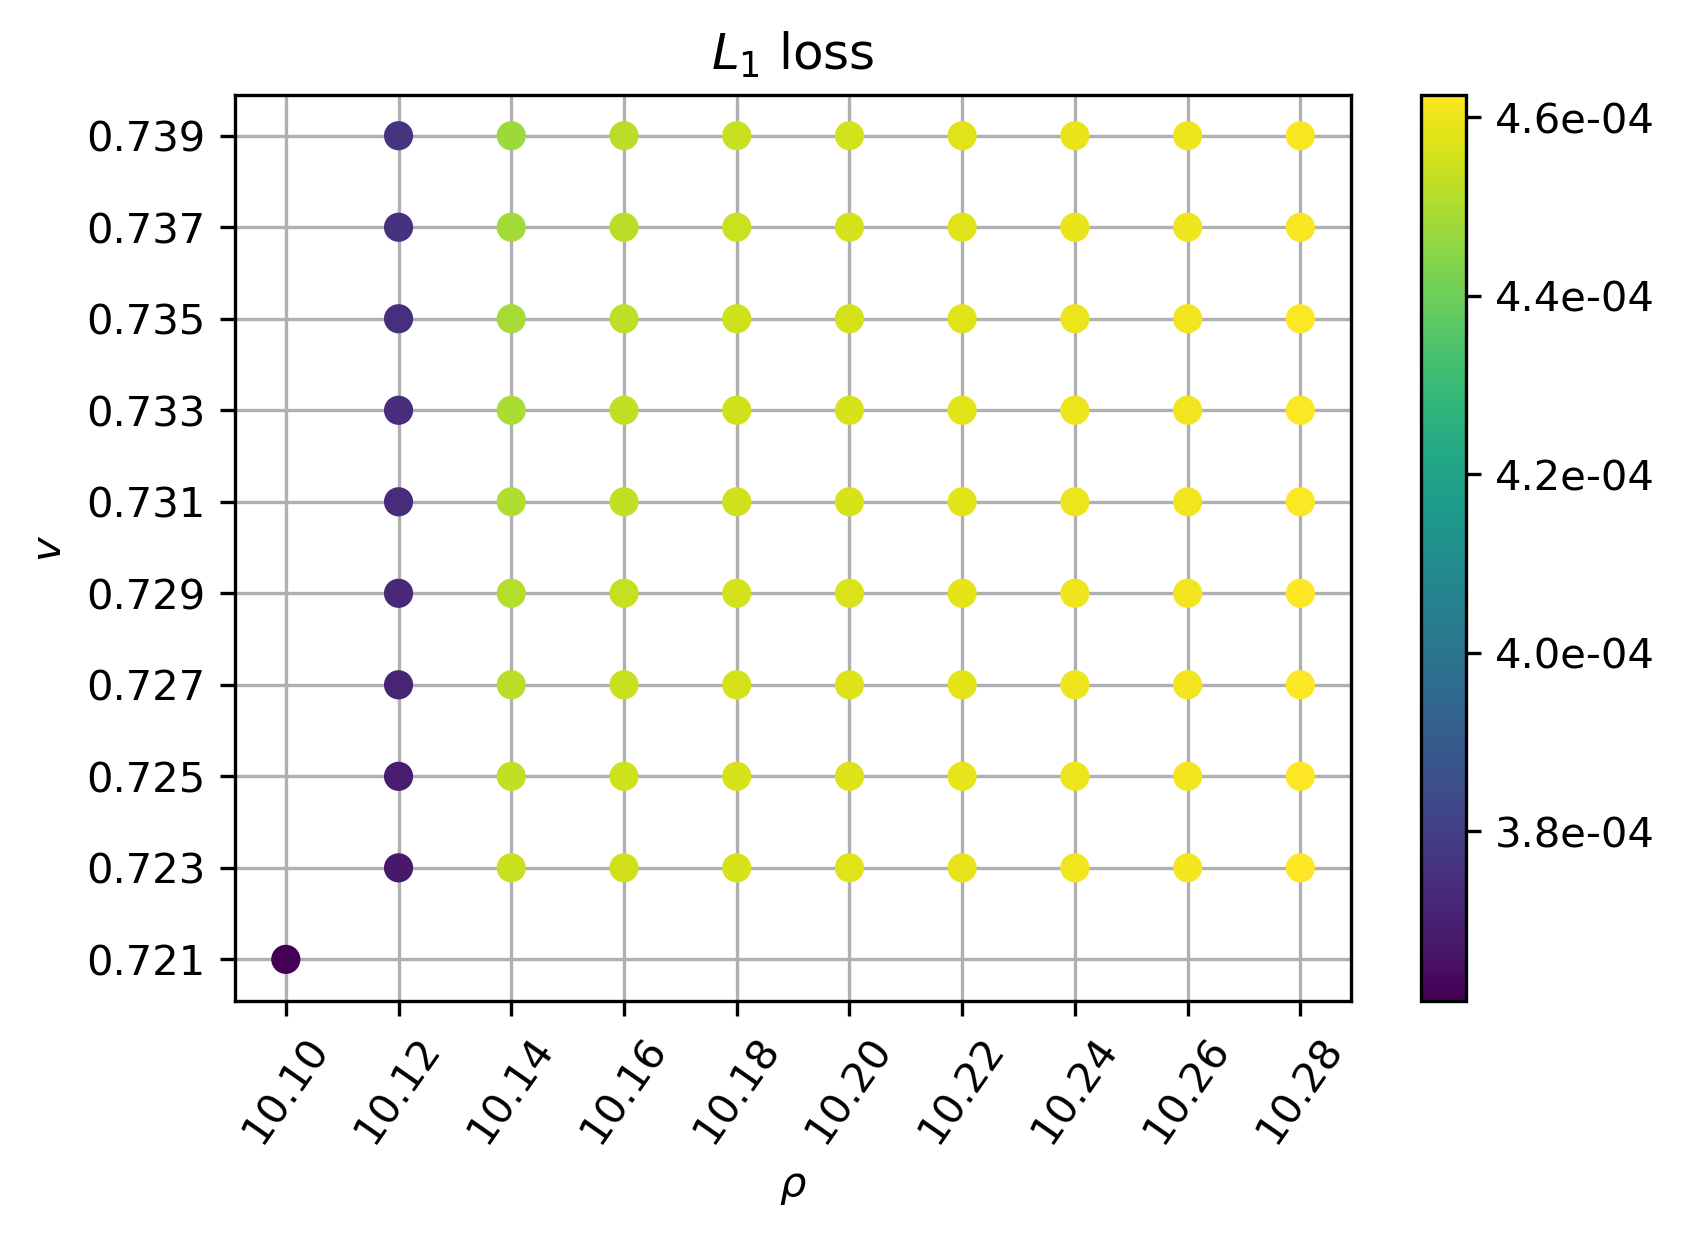

In [184]:
plt.scatter(sub_df_rho_v["rho max"], sub_df_rho_v["v max"], c=sub_df_rho_v["L1"], zorder=5)
plt.colorbar(format='%0.1e')
plt.xlabel(r"$\rho$")
plt.xticks(list(set(sub_df_rho_v["rho max"])), rotation=55)
plt.yticks(list(set(sub_df_rho_v["v max"])))
plt.grid()
plt.ylabel(r"$v$")
plt.title(r"$L_1$ loss")
plt.savefig("error_analysis_rho_v.pdf", bbox_inches='tight')
plt.show()

In [ ]:
# plt.pcolormesh(X, Y, Z, cmap=plt.cm.get_cmap('Blues'))

Save this data to process later on:

In [140]:
# df.to_csv("Data/errors_analysis_v2.csv")

# Get parameters of network out:

In [47]:
with torch.no_grad():
    for param in NNC2P.parameters():
        print(param)

Parameter containing:
tensor([[-0.3637,  0.4540, -0.4355],
        [ 0.0066,  0.6949,  0.4879],
        [ 0.1112, -0.0925,  0.1091],
        ...,
        [ 0.5306, -0.4535, -0.3026],
        [-0.4308, -0.1415,  0.2810],
        [ 0.6349, -0.2947,  0.0561]], requires_grad=True)
Parameter containing:
tensor([ 0.5675,  0.2904, -0.7667, -0.3078, -0.1945,  0.0523,  0.0514, -0.4138,
         0.2312, -0.5222,  0.2495, -0.3197, -0.4844, -0.5024, -0.3668, -0.2699,
         0.7860,  0.7489,  0.1024,  0.8798,  0.1536, -0.4353, -0.3389, -0.5969,
        -0.4334, -0.7355, -0.4756, -0.4140, -0.1220, -0.1788, -0.7250, -0.0075,
         0.2842,  0.1193,  0.5405, -0.1805, -0.0228, -0.3408, -0.1134, -0.2822,
         0.5498, -0.1406,  0.3311, -0.5858,  0.0567, -0.2661,  0.3879,  0.8417,
        -0.2426,  0.5311,  0.0035,  0.1361, -0.3355,  0.2191, -0.3657,  0.0739,
        -0.7668, -0.7611, -0.4528,  0.7155,  0.4711,  0.1546, -0.7966, -0.6006,
         0.5338, -0.4438, -0.5507,  0.2647, -0.5531, -0.1843